# <font color=yellow> Integrating an FX Trading platform </font>

The sample is intended to demonstrate how FX deals (Spot and Forward) can be managed using Kyriba APIs. It allows to:

*   Create new deals with status "Pre-trade".
*   Input confirmed Spot and Forward rates.
*   Update existing Pre-trade deals to Actuals by importing confirmed rates.

Please see below the FX trading process diagram.\
Two scenarios are possible: Kyriba initiated or FX Trading platform initiated deals.\
This sample cover the first one.

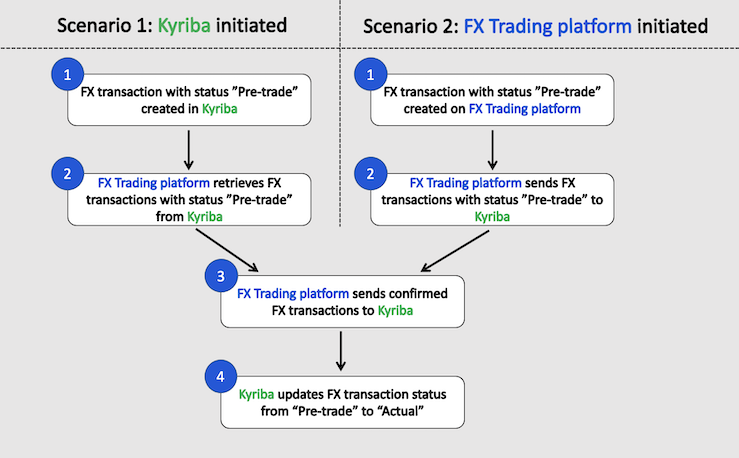

## <font color='yellow'>Step 0.1: Code for token generation and API management</font>
      

In [ ]:
#@title Select **servicePack** the Sample should run
from subprocess import getstatusoutput
servicePack = 'DEMO' #@param ['DEMO'] {allow-input: true}

if servicePack == 'DEMO':
  branch = 'main'
else:
  branch = servicePack
print(branch)
rm = getstatusoutput("rm Colab_shared_code_for_API_usage -rf ") 
clone = getstatusoutput("git clone -l -s --branch " +  branch + " https://github.com/kyriba/Colab_shared_code_for_API_usage.git") 
import importlib

enableFormatterDF = True #@param {type:"boolean"}
from google.colab import data_table

if enableFormatterDF is True:
  data_table.enable_dataframe_formatter()
else:
  data_table.disable_dataframe_formatter()

try:  
  importlib.reload(sample_requests)
except:
  print()
  
from Colab_shared_code_for_API_usage import sample_requests

In [ ]:
#@title Import custom modules
import time
from datetime import datetime,date
import json as js


## <font color='yellow'>Step 0.2: Connect and  retrieve token</font>

In [ ]:
#@title <font color='lime'>Connect</font>
print('token:')
token = sample_requests.login()

## <font color='yellow'>Step 1: Create Pre-trade FX deals</font>

Pre-trade FX deals can either be created in Kyriba or on an FX Trading platform.


In [ ]:
#@title <font color='lime'>Fill in the form with Pre-trade FX deal data</font>
#@markdown Fill in the form and run the cell to import Pre-trade FX deals to Kyriba.


direction = "BUY" #@param ["BUY", "SELL"]
transaction_category = "SPOT" #@param ["SPOT", "FORWARD"]
transaction_date = "2023-02-07" #@param {type:"date"}
maturity_date = "2023-03-10" #@param {type:"date"}
transaction_currency = "EUR" #@param ["EUR", "USD", "GBP"]
transaction_amount = 200.00 #@param {type:"number"}
countervalue_currency = "USD" #@param ["EUR", "USD", "GBP"]
countervalue_amount = 92.00 #@param {type:"number"}
spot_rate = 0.9150 #@param {type:"number"}
reference = "TEST01" #@param {allow-input: true, type: "string"}
#@markdown The below fields are used for Forward deals only
delivery_date = "2023-03-13" #@param {type:"date"}
forward_rate = 0.9200 #@param {type:"number"}
#@markdown ---
traces = False #@param {type:"boolean"}

today = date.today()
now = datetime.now()
dt_string = str(today) + 'T' + now.strftime("%H:%M:%S")

if direction == "BUY":
  direction = "B"
elif direction == "SELL":
  direction = "S"


if transaction_currency == countervalue_currency:
    print("\033[93mTransaction and Countervalue currencies MUST NOT match.\n")
    print("Please select correct currencies and try again.\033[1;4m")
elif maturity_date < transaction_date:
    print("\033[93mMaturity date MUST BE equal or greater than Transaction date.\n")
    print("Please select correct dates and try again.\033[1;4m")
elif delivery_date < maturity_date:
    print("\033[93mDelivery date MUST BE equal or greater than Maturity date.\n")
    print("Please select correct dates and try again.\033[1;4m")
elif transaction_amount <= 0 or countervalue_amount <= 0:
    print("\033[93mTransaction and Countervalue amounts MUST BE greater than 0.\n")
    print("Please enter correct amounts and try again.\033[1;4m")
elif spot_rate <= 0:
    print("\033[93mSpot rate MUST BE greater than 0.\n")
    print("Please enter correct Spot rate and try again.\033[1;4m")
elif transaction_category == 'FORWARD' and forward_rate <= 0:
    print("\033[93mForward rate MUST BE greater than 0.\n")
    print("Please enter correct Forward rate and try again.\033[1;4m")
else:
    data = "P;" + reference + ";" + direction + ";" + transaction_category + \
    ";COMPANY-DEMO;BANK-DEMO;" + transaction_date + ";" + maturity_date + ";" + \
    delivery_date + ";" + transaction_currency + ";" + str(transaction_amount) + ";" + \
    countervalue_currency + ";" + str(countervalue_amount) + ";" + str(spot_rate) + ";" + str(forward_rate)

    filename = "FX_Pre_" + dt_string + "-" + reference + ".csv"

    res = sample_requests.import_data(token, data, filename,'API_FX_ADD', True, traces)
    print('\r\ndata pushed to Kyriba Application: ' + filename)


## <font color='yellow'>Step 2: Retrieve FX deals with status "Pre-trade" stored in Kyriba</font>


In [ ]:
#@title <font color='lime'>List all the Pre-trade FX deals stored in Kyriba</font> { display-mode: "form" }


import pandas as pd


res2 = sample_requests.run_report(token,'API_FX_EXP')
buffer = sample_requests.StringIO(res2)
df = sample_requests.pd.read_csv(buffer,delimiter=';',names=['Purpose','ID','Buy/Sell','Code','Type','Reference','Trans. Date','Maturity Date','Delivery Date','Trans. Ccy','Trans. Amount','Countervalue Ccy','Countervalue Amount','Spot Rate', 'Forward Rate'],index_col=False)
df = df.loc[df['Purpose']=='P']
df.reset_index(drop=True, inplace=True)
df.index = df.index + 1
display(df)


## <font color='yellow'>Step 3: Import confirmed FX deals to Kyriba</font>


In [ ]:
#@title <font color='lime'>Select a transaction</font> { display-mode: "form" }
#@markdown Run the cell and select a transaction you would like to confirm from the dropdown list.\
#@markdown The transactions in the list are Pre-trade FX deals stored in Kyriba. 

import ipywidgets as widgets

res5 = sample_requests.run_report(token,'API_FX_EXP')
pretrades = dict()
alltrades = list(map(lambda x: x.split(';'), res5.split('\n')))
for trans in alltrades:
  if trans[0] == 'P':
    pretrades[trans[1]] = trans[1:-1]

dropdown = widgets.Dropdown(
    options=pretrades,
    description='Transaction:',
    disabled=False
)

display(dropdown)

In [ ]:
#@title <font color='lime'>Provide confirmed Spot rate</font> { display-mode: "form" }
#@markdown Run the cell and enter confirmed Spot rate.

import ipywidgets as widgets


new_spot_rate = widgets.BoundedFloatText(
    min=0,
    max=999999,
    description='Spot Rate:',
    disabled=False
)

display(new_spot_rate)

In [ ]:
#@title <font color='lime'>Provide confirmed Forward rate (for Forward deals only)</font> { display-mode: "form" }
#@markdown Run the cell and enter confirmed Forward rate.

import ipywidgets as widgets


new_fw_rate = widgets.BoundedFloatText(
    min=0,
    max=999999,
    description='Forward Rate:',
    disabled=False
)

display(new_fw_rate)

In [ ]:
#@title <font color='lime'>Import confirmed FX deals</font> { display-mode: "form" }
#@markdown Run the cell to import confirmed FX deals to Kyriba.\
#@markdown Once done, transaction status will be changed from "Pre-trade" to "Actual".

traces = False #@param {type:"boolean"}

try: 
    dropdown
    if dropdown.value == None:
        print('There are no Pre-trade transactions stored in Kyriba at the moment.')
        print('Please create one using the form at Step 1 and try again.')
    elif not dropdown.value[0]:
        print('The previously selected transaction has already been confirmed.')
        print('Please select another one.')
    elif 'FWD' in dropdown.value[0]:
        try: 
            new_fw_rate
        except NameError:
            print('Please enter Forward rate.')
except NameError:
    print('Please select a transaction.')

try: 
    new_spot_rate
except NameError:
    print('Please enter Spot rate.')


try:
    vals = dropdown.value
    confirmed_data = vals[0] + ';' + vals[4] + ';' + vals[1] + ';COMPANY-DEMO;BANK-DEMO;'\
    + vals[5] + ';' + vals[6] + ';' + vals[7] + ';' + vals[8] + ';' + vals[10] + ';;'\
    + str(new_spot_rate.value) + ';'

    if 'FWD' in dropdown.value[0]:
        confirmed_data += str(new_fw_rate.value)
    else:
        confirmed_data += ''

    today = date.today()
    now = datetime.now()
    dt_string = str(today) + 'T' + now.strftime("%H:%M:%S")
    filename = "FX_Act" + dt_string + ".csv"

    if new_spot_rate.value == 0:
        print('\033[93mSpot rate cannot be equal to 0.')
        print('Please enter correct value and try again.')
    elif 'FWD' in dropdown.value[0] and new_fw_rate.value == 0:
        print('\033[93mForward rate cannot be equal to 0.')
        print('Please enter correct value and try again.')
    else:
        res3 = sample_requests.import_data(token, confirmed_data, filename,'API_FX_UPD', True, traces)
        print('\r\ndata pushed to Kyriba Application: ' + filename)
        if js.loads(res3)['status'] == 'Complete':
            id_latest = dropdown.value[0]
            dropdown.value[0] = False

except (NameError, TypeError):
    print('\n\033[93mConfirmed deal has not been pushed to the application.')
    print('Please see the reason above.')

## <font color='yellow'>Step 4: Retrieve FX deals with status "Actual" stored in Kyriba</font>


In [ ]:
#@title <font color='lime'>Display the most recent confirmed FX deal</font> { display-mode: "form" }
import pandas as pd
res5 = sample_requests.run_report(token,'API_FX_EXP')
buffer = sample_requests.StringIO(res5)
df3 = sample_requests.pd.read_csv(buffer,delimiter=';',names=['Purpose','ID','Buy/Sell','Code','Type','Reference','Trans. Date','Maturity Date','Delivery Date','Trans. Ccy','Trans. Amount','Countervalue Ccy','Countervalue Amount','Spot Rate', 'Forward Rate'],index_col=False)
df3 = df3.loc[df3['Purpose']=='A']
try:
    df3 = df3.loc[df3['ID']==id_latest]
    df3.reset_index(drop=True, inplace=True)
    df3.index = df3.index + 1
    display(df3)
except NameError:
    print('There were no FX deals confirmed during this session.')

In [ ]:
#@title <font color='lime'>List all the Actual FX deals stored in Kyriba</font> { display-mode: "form" }
import pandas as pd
res4 = sample_requests.run_report(token,'API_FX_EXP')
buffer = sample_requests.StringIO(res4)
df2 = sample_requests.pd.read_csv(buffer,delimiter=';',names=['Purpose','ID','Buy/Sell','Code','Type','Reference','Trans. Date','Maturity Date','Delivery Date','Trans. Ccy','Trans. Amount','Countervalue Ccy','Countervalue Amount','Spot Rate', 'Forward Rate'],index_col=False)
df2 = df2.loc[df2['Purpose']=='A']
df2.reset_index(drop=True, inplace=True)
df2.index = df2.index + 1
display(df2)